In [1]:
from standardInclude import *
from fit_util import *
from omega_a_fitting import *
from pileup_correction import *
from lost_muon_calculation import *

import uncertainties
import sys

Welcome to JupyROOT 6.12/06
For interactive plots, run: setint()
To return to non-interactive plots (default state), run: noint()


# Quick (5-par) NA^2 sliding fit

---

In [2]:
#f = r.TFile("./data/EndGame4042BFinalRandNon_pileup_corrected.root")
f = r.TFile("./data/combined.root")
f.cd("clustersAndCoincidences")
f.ls()

h3 = f.Get("clustersAndCoincidences/corrected").Clone()

TFile**		./data/combined.root	
 TFile*		./data/combined.root	
  TDirectoryFile*		clustersAndCoincidences	clustersAndCoincidences
   KEY: TH3D	uncorrected;1	uncorrected
   KEY: TH3D	corrected;1	corrected
   KEY: TH2I	triples;1	triples
   KEY: TH2I	quadruples;1	quadruples
   KEY: TH1I	ctag;1	ctag
  KEY: TDirectoryFile	clustersAndCoincidences;1	clustersAndCoincidences


In [3]:
#h3.GetYaxis().SetRangeUser(1700,3200)
h = h3.Project3D("yx").Clone("h")
h.SetDirectory(0)

In [5]:
def doWiggleFit( wiggle , tlow = 30, thigh = 650):
    fitFunc = WiggleFit(GetBlindingPhrase("../fitting/blinding.txt"), "5par")
    fit = BuildTF1(fitFunc, 5, "5par", "five_parameter_fit", tlow, thigh)
    fit.SetParameters([7000000,64.4,0.33,-33,0])
    fit.SetParNames()
    fitter = WiggleFitter(wiggle.h, fit, "5par", "REMBQ", 1)
    fitter.f.SetParLimits(1,0.00001,1000000000)
    fitter.Fit(2)
    parameters = [fitter.f.GetParameter(i) for i in range(5)]
    parerrors = [fitter.f.GetParError(i) for i in range(5)]
    return (parameters, parerrors)
    

def computeNAsquare( elow, ehigh, estep, hist_2d, tlow, thigh, calo=0 ):
    NAsquare = []
    NAsquare_error = []
    energies = []
    for e1 in range(elow, ehigh, estep):
        e2 = e1+estep
        print("Starting energy range", e1, e2)
        wiggle = MakeWiggleFromTH2(h, e1, e2, calo, 1, True)
        results = doWiggleFit(wiggle, tlow, thigh)
        Ni = uncertainties.ufloat( results[0][0] , results[1][0])
        Ai = uncertainties.ufloat(results[0][2] , results[1][2])
        NAsquarei = Ni*Ai*Ai
        NAsquare.append( NAsquarei.n )
        NAsquare_error.append( NAsquarei.s )
        energies.append((e1+e2)/2)
    return(NAsquare, energies, NAsquare_error)

---

### We want these bins to be at well defined points of g-2 periods, so lets find a g-2 0 crossing and then go forward from there

Thought is to go in quarter periods, and then do the analysis at a later point. So lets first determine where the 0 crossing is

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


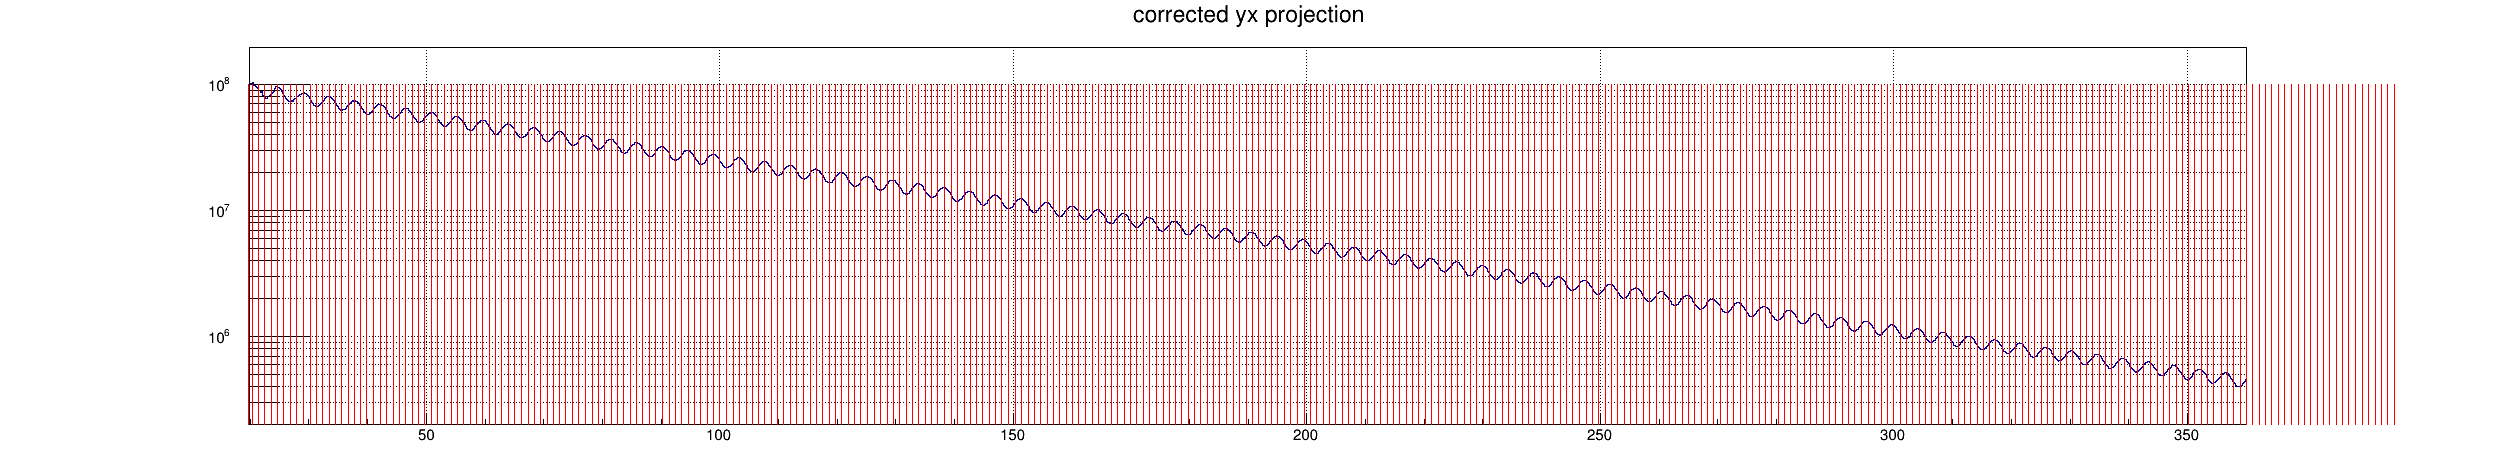

In [7]:
c = r.TCanvas("c","c",2500,500)
h.GetXaxis().SetRangeUser(20,600)
hi = h.ProjectionX().Clone()
hi.Draw("colz")
c.SetGrid()

startTimes = []
placeInPeriod = []
g2Period = 4.37
startTime = 30.2 - g2Period*6
lines = []

for i in range(350):
    #if(i % 3 is not 0):
    #    continue
    bini = hi.FindBin( startTime + g2Period/4.0*i ) 
    placeInPeriod.append( i % 4 )
    time = hi.GetBinCenter( bini ) - hi.GetBinWidth( bini )/2.0
    #print(time)
    linei = r.TLine(time, 0, time, 100000000)
    linei.SetLineColor(2)
    lines.append(linei.Clone())
    lines[len(lines) - 1].Draw("SAME")
    startTimes.append(time)

hi.GetXaxis().SetRangeUser(20,360)
c.SetLogy()
c.Draw()

---

### Now that we have our start times and widths, lets run the tests

In [9]:
eLow = 1100
eHigh = 3200
eWidth = 100
nPeriods = 12

rangeToRun = [20,22]


NAsquare_byTime = []

#for t1 in np.linspace(timeStart, timeEnd, nBins):
for woeidjwe in range(rangeToRun[0], rangeToRun[1]):
    print("*****************************************************************************************************")
    t1 = startTimes[woeidjwe]
    t2 = t1 + g2Period*nPeriods
    print("Starting time range: ", t1,t2)
    ding,dong,error = computeNAsquare(eLow, eHigh, eWidth, h, t1, t2)
    NAsquare_byTime.append((t1, t2, ding,dong,error, eLow, eHigh, eWidth, nPeriods, placeInPeriod[woeidjwe], woeidjwe))

*****************************************************************************************************
Starting time range:  25.7143 78.1543
Starting energy range 1100 1200
Starting fit 1 / 1
Parameters from this fit: 
     ChiSq/NDF =  699.3470607358431 / 346 = 2.0212342795833615
      N  =  6168573.698872971 +/- 666.5333025037104
      #tau_{#mu}  =  64.0014215038661 +/- 0.008736372736350972
      A  =  0.029056649352907034 +/- 4.57195497349865e-05
      R  =  -15.810719284717443 +/- 72.28627537221737
      #phi_{a}  =  -1.0965184083355783 +/- 0.0052533327020982375
Starting energy range 1200 1300
Starting fit 1 / 1
Parameters from this fit: 
     ChiSq/NDF =  924.441365623184 / 346 = 2.6717958544022657
      N  =  6137884.929178326 +/- 643.8300073932519
      #tau_{#mu}  =  64.01929120958125 +/- 0.008477107904525383
      A  =  0.05419121908448533 +/- 4.517009240833991e-05
      R  =  -123.48134762298928 +/- 40.83721953369756
      #phi_{a}  =  -1.0727487759865144 +/- 0.00298276814016

Warning in <TF1::AddToGlobalList>: Function is supposed to be in the global list but it is not present
Warning in <TF1::AddToGlobalList>: Function is supposed to be in the global list but it is not present
Warning in <TF1::AddToGlobalList>: Function is supposed to be in the global list but it is not present
Warning in <TF1::AddToGlobalList>: Function is supposed to be in the global list but it is not present
Warning in <TF1::AddToGlobalList>: Function is supposed to be in the global list but it is not present
Warning in <TF1::AddToGlobalList>: Function is supposed to be in the global list but it is not present
Warning in <TF1::AddToGlobalList>: Function is supposed to be in the global list but it is not present
Warning in <TF1::AddToGlobalList>: Function is supposed to be in the global list but it is not present
Warning in <TF1::AddToGlobalList>: Function is supposed to be in the global list but it is not present
Warning in <TF1::AddToGlobalList>: Function is supposed to be in the glob

In [12]:
df = pandas.DataFrame(NAsquare_byTime, columns=None)
df.head()

df.to_csv("./slidingNAsquare_eLow_"+str(eLow)+"_eHigh_"+str(eHigh)+"_eWidth_"+str(eWidth)+"_nPeriods_"+str(nPeriods)+"_"+str(rangeToRun[0]).zfill(4)+".csv",
         sep="|")